In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import re

file_name = "data/GloVe/glove.6B.50d.txt"

embedding = {}
idx_to_word = {}
word_to_idx = {}
bad_lines = 0

with open(file_name, 'r', encoding='UTF-8') as f:
    for idx, line in enumerate(f):
        try:
            line = line.strip()
            match_obj = re.match(r'([^\s]+)', line)
            word = match_obj.group(1)
            word_len = len(word)
            word_vec = line[word_len:].replace('\n', '')

            embed = word_vec.strip()
            embed = embed.split()
            embed = np.array(embed, dtype=np.float32)
            
            embedding[idx] = [embed]
            idx_to_word[idx] = word.strip()
            word_to_idx[word.strip()] = idx
        except:
            bad_lines += 1

print(f'Bad lines: {bad_lines}')

Bad lines: 0


In [4]:
from sklearn.metrics.pairwise import cosine_similarity

w1 = 'banana'
w2 = 'fruit'

w1_embed = embedding[word_to_idx[w1]]
w2_embed = embedding[word_to_idx[w2]]
cosine_similarity(w1_embed, w2_embed)


array([[0.71814054]], dtype=float32)

In [5]:
df = pd.read_csv('data/opted/OPTED-Dictionary.csv')

In [6]:
df.head()

,Word,Count,POS,Definition
0,A,1,"""""","""The first letter of the English and of many o..."
1,A,1,"""""","""The name of the sixth tone in the model major..."
2,A,1,"""""","""An adjective commonly called the indefinite ..."
3,A,1,"""""","""In each; to or for each; as """"""""twenty leagu..."
4,A,1,"""prep.""","""In; on; at; by."""


In [7]:
df["Word"] = df["Word"].str.lower()

In [8]:
df["Word"][100]

'abate'

In [9]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
chars_to_remove = re.compile(r'[{}]'.format(re.escape(string.punctuation)))
df["Definition"] = df["Definition"].map(lambda x: chars_to_remove.sub('', x).lower())

In [11]:
df.head()

,Word,Count,POS,Definition
0,a,1,"""""",the first letter of the english and of many ot...
1,a,1,"""""",the name of the sixth tone in the model major ...
2,a,1,"""""",an adjective commonly called the indefinite a...
3,a,1,"""""",in each to or for each as twenty leagues a da...
4,a,1,"""prep.""",in on at by


In [12]:
print(df["Definition"][3])

in each to or for each as  twenty leagues a day a hundred pounds a year a dollar a yard etc


In [13]:
df.shape

(176009, 4)

In [14]:
df = df[df["Word"].isin(word_to_idx.keys())]

In [30]:
df.shape

(102236, 4)

In [31]:
df = df[df["Word"] != ""]
df = df[df["Definition"] != ""]

In [32]:
df.shape

(102234, 4)

In [16]:
from transformers import TFBertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [35]:
seq_length = 512

def generate_sequences(dataset):
    num_sequences = dataset.shape[0]

    x_token = np.zeros((num_sequences, seq_length))
    x_mask = np.zeros((num_sequences, seq_length))
    y_token = np.zeros((num_sequences, 50), dtype=np.float64)

    for i in range(0, num_sequences):
        try:
            word = dataset["Word"].iloc[i]
            definition = dataset["Definition"].iloc[i]

            tokens = tokenizer.tokenize(definition)
            input = tokenizer.encode_plus(tokens, max_length=seq_length, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
            
            x_token[i, :] = input['input_ids']
            x_mask[i, :] = input['attention_mask']
            y_token[i, :] = embedding[word_to_idx[word]][0]
        
        except:
            print(f'Error on {i}')


    print(f'Number of sequences: {num_sequences}')

    return x_token, x_mask, y_token, num_sequences

x_token, x_mask, y_token, num_sequences = generate_sequences(df[["Word", "Definition"]])

Number of sequences: 102234


In [45]:
dataset = tf.data.Dataset.from_tensor_slices((x_token, x_mask, y_token))
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (50,)), types: (tf.float64, tf.float64, tf.float64)>

In [46]:
def combine_input_mask(input_id, mask, y_token):
    return {'input_ids': input_id, 'attention_mask': mask}, y_token

dataset = dataset.map(combine_input_mask)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (50,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [47]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 50)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [48]:
split = 0.8
sample_size = int((num_sequences // batch_size) * split)
ds_train = dataset.take(sample_size)
dataset_validation = dataset.skip(sample_size)

test_split = 0.5
testset_size = len(list(dataset_validation))
val_sample_size = int(testset_size * test_split)
ds_val = dataset_validation.take(val_sample_size)
ds_test = dataset_validation.skip(val_sample_size)
print(f'tensor: {ds_train.take(1)}\nsize: {len(list(ds_train))}')
print(f'tensor: {ds_val.take(1)}\nsize: {len(list(ds_val))}')
print(f'tensor: {ds_test.take(1)}\nsize: {len(list(ds_test))}')

tensor: <TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 50)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>
size: 5111
tensor: <TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 50)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>
size: 639
tensor: <TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 50)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>
size: 639


In [40]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2021-11-19 01:13:11.109747: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further tr

In [49]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

input_layer = Input(shape=(seq_length,), name='input_ids', dtype=tf.int32)
mask_layer = Input(shape=(seq_length,),
                   name='attention_mask', dtype=tf.int32)

embedding_layer = bert.bert(input_layer, attention_mask=mask_layer)[1]

out = Dense(1024, activation='relu')(embedding_layer)
out = Dropout(0.2)(out)
out = Dense(50)(out)

model = Model(inputs=[input_layer, mask_layer], outputs=out)

model.layers[2].trainable = False

optimizer = SGD(learning_rate=0.00009, decay=1e-6)
model.compile(optimizer=optimizer,
              loss=tf.losses.mean_squared_error, metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         multiple             109482240   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 dense_4 (Dense)                (None, 1024)         787456      ['bert[2][1]']             

In [50]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('reverse_model.h5', monitor='val_loss',
                     mode='min', save_best_only=True, verbose=1)

history = model.fit(ds_train, validation_data=ds_val,
                    batch_size=16, epochs=100, shuffle=True, verbose=1, callbacks=[es, mc])

Epoch 1/100
5111/5111 [==============================] - ETA: 0s - loss: 0.5097 - accuracy: 0.0974
Epoch 00001: val_loss improved from inf to 0.41106, saving model to reverse_model.h5
5111/5111 [==============================] - 2303s 450ms/step - loss: 0.5097 - accuracy: 0.0974 - val_loss: 0.4111 - val_accuracy: 0.2909
Epoch 2/100
5111/5111 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.1451
Epoch 00002: val_loss improved from 0.41106 to 0.40536, saving model to reverse_model.h5
5111/5111 [==============================] - 2269s 444ms/step - loss: 0.4633 - accuracy: 0.1451 - val_loss: 0.4054 - val_accuracy: 0.2973
Epoch 3/100
5111/5111 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.1625
Epoch 00003: val_loss improved from 0.40536 to 0.40161, saving model to reverse_model.h5
5111/5111 [==============================] - 2170s 425ms/step - loss: 0.4519 - accuracy: 0.1625 - val_loss: 0.4016 - val_accuracy: 0.2997
Epoch 4/100
5111/5111 [===

In [51]:
loss, accuracy = model.evaluate(ds_test, verbose=0)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 28.72%


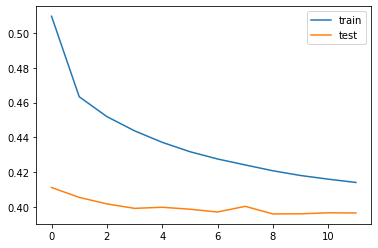

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()